In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import sklearn
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
print("scikit-learn version: {}". format(sklearn.__version__))

import optuna
import optuna.integration.lightgbm as lgb
print("Optuna version:  {}".format(optuna.__version__))

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

scikit-learn version: 0.23.2


Optuna version:  2.9.1
/kaggle/input/tabular-playground-series-sep-2021/train.csv
/kaggle/input/tabular-playground-series-sep-2021/test.csv
/kaggle/input/tabular-playground-series-sep-2021/sample_solution.csv


In [2]:
# read input files
df_train = pd.read_csv("../input/tabular-playground-series-sep-2021/train.csv")
df_test = pd.read_csv("../input/tabular-playground-series-sep-2021/test.csv")
sample_submission = pd.read_csv("../input/tabular-playground-series-sep-2021/sample_solution.csv")

feature_cols = [col for col in df_train.columns if col.startswith("f")]
target=df_train.claim

# adding the magic feature, see https://www.kaggle.com/c/tabular-playground-series-sep-2021/discussion/270206
df_train['NaNs'] = df_train[feature_cols].isna().sum(axis=1)
df_test['NaNs'] = df_test[feature_cols].isna().sum(axis=1)
feature_cols += ['NaNs']

In [3]:
# dividing X, y into train and test data
X = df_train[feature_cols]
y = df_train.claim
X_train, X_val, y_train, y_val = train_test_split(X, y, random_state = 29, stratify=y)
display(X_train.shape)

(718439, 119)

In [4]:
dtrain = lgb.Dataset(X_train, label=y_train)
dval = lgb.Dataset(X_val, label=y_val)

Here the optuna tuning round starts. 
The goal is to get the best hyperparameters. 
As tuning takes a long time I just saved the hyperparameters and trained a new LightGBM with those the next day.

In [5]:
params = {
        "objective": "binary",
        "metric": "auc",
        "verbosity": -1,
        "boosting_type": "gbdt",
    }

In [6]:
#model = lgb.train(
#        params, 
#        dtrain, 
#        valid_sets=[dtrain, dval], 
#        verbose_eval=100, 
#        early_stopping_rounds=100
#    )

In [7]:
#best_params = model.params
#print("Best params:", best_params)

In [8]:
#print("  Params: ")
#for key, value in best_params.items():
#        print("    {}: {}".format(key, value))

In [9]:
#pred_val = model.predict(X_val, num_iteration=model.best_iteration)
#pred_val

In [10]:
#roc_auc_score(y_val, pred_val)

New model with the tuned hyperparameters. Note: you could modifiy the code so that it runs in 1 Step only.

In [11]:
import lightgbm as lgb
print("LightGBM version:  {}".format(lgb.__version__))

LightGBM version:  3.2.1


In [12]:
tuned_params = {'objective': 'binary', 
                'metric': 'auc', 
                #'verbosity': -1, 
                'boosting_type': 'gbdt', 
                #'feature_pre_filter': False, 
                'lambda_l1': 9.933190464117825, 
                'lambda_l2': 0.03251810602204929, 
                'num_leaves': 7, 
                'feature_fraction': 1.0, 
                'bagging_fraction': 0.8694099317439226, 
                'bagging_freq': 4, 
                'min_child_samples': 25, 
                'num_iterations': 2000 # 1000 from the tuner
                }

In [13]:
model = lgb.train(
        tuned_params, 
        dtrain, 
        valid_sets=[dtrain, dval], 
        valid_names=['train','val'],
        verbose_eval=50,
        early_stopping_rounds=100
    )

/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Info] Number of positive: 358136, number of negative: 360303
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.699176 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 30090
[LightGBM] [Info] Number of data points in the train set: 718439, number of used features: 119
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.498492 -> initscore=-0.006033
[LightGBM] [Info] Start training from score -0.006033
Training until validation scores don't improve for 100 rounds
[50]	train's auc: 0.809815	val's auc: 0.808547
[100]	train's auc: 0.813841	val's auc: 0.811498
[150]	train's auc: 0.815789	val's auc: 0.812888
[200]	train's auc: 0.817091	val's auc: 0.813546
[250]	train's auc: 0.818141	val's auc: 0.814126
[300]	train's auc: 0.819136	val's auc: 0.814518
[350]	train's auc: 0.819984	val's auc: 0.814735
[400]	train's auc: 0.820852	val's auc: 0.814836
[450]	train's auc: 0.821726	val's auc: 0.815036
[500]

In [14]:
prediction = model.predict(df_test[feature_cols]) # gives a probability!
prediction

array([0.59348021, 0.12073744, 0.60949489, ..., 0.75826761, 0.13788943,
       0.75448029])

In [15]:
#lgb.plot_metric(model, metric="auc", figsize=(14,8))

<AxesSubplot:title={'center':'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

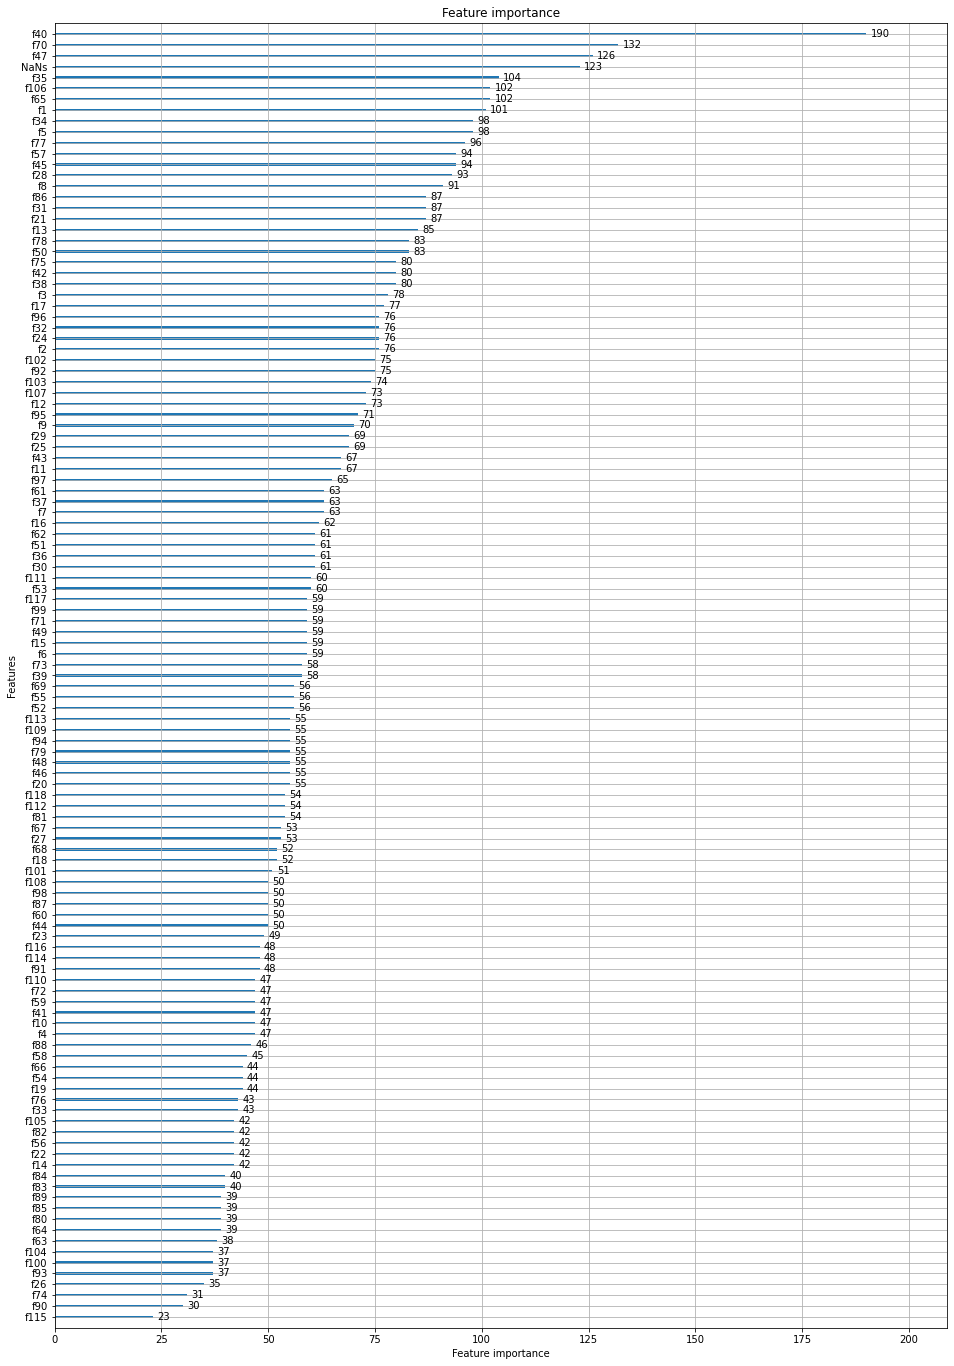

In [16]:
lgb.plot_importance(model, figsize=(16,24))

In [17]:
# generate submission file 
submission_lgbm = pd.DataFrame(data={"id" : sample_submission.id,
                                     "claim" : prediction})

submission_lgbm.to_csv('submission_lgbm.csv', index=False)
submission_lgbm.head()

,id,claim
0,957919,0.593480
1,957920,0.120737
2,957921,0.609495
3,957922,0.113833
4,957923,0.141376


In [18]:
# retrain on whole data and make a new submission file
dtrain = lgb.Dataset(df_train[feature_cols], label=df_train.claim)
model2 = lgb.train(
        tuned_params, 
        dtrain
    )

/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Info] Number of positive: 477515, number of negative: 480404
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.974738 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 30091
[LightGBM] [Info] Number of data points in the train set: 957919, number of used features: 119
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.498492 -> initscore=-0.006032
[LightGBM] [Info] Start training from score -0.006032


In [19]:
prediction = model2.predict(df_test[feature_cols])

In [20]:
# generate submission file 
submission_lgbm2 = pd.DataFrame(data={"id" : sample_submission.id,
                                     "claim" : prediction})

submission_lgbm2.to_csv('submission_lgbm2.csv', index=False)
submission_lgbm2.head()

,id,claim
0,957919,0.579502
1,957920,0.118619
2,957921,0.625412
3,957922,0.120163
4,957923,0.145224


Adding another experiment: train with 10 different random seeds and average the results

In [21]:
random_state = (1,3,34,53,61,63,77,78,99,104)
avg_prediction=np.zeros(df_test[feature_cols].shape[0])
for rs in random_state:
    tuned_params = {'objective': 'binary', 
                'metric': 'auc', 
                'verbosity': -1, 
                'boosting_type': 'gbdt', 
                #'feature_pre_filter': False, 
                'lambda_l1': 9.933190464117825, 
                'lambda_l2': 0.03251810602204929, 
                'num_leaves': 7, 
                'feature_fraction': 1.0, 
                'bagging_fraction': 0.8694099317439226, 
                'bagging_freq': 4, 
                'min_child_samples': 25, 
                'num_iterations': 10, # 1000 from the tuner
                'random_state': rs # new
                }


    dtrain = lgb.Dataset(df_train[feature_cols], label=df_train.claim)
    model3 = lgb.train(
        tuned_params, 
        dtrain
    )
    prediction = model3.predict(df_test[feature_cols])
    avg_prediction = np.add(avg_prediction,prediction/len(random_state))
avg_prediction

/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


array([0.55297459, 0.26336302, 0.55686498, ..., 0.66473303, 0.26336302,
       0.66543796])

In [22]:
random_state = (1,3,5,4)
sum_array= np.array([0,0,0,0])
for rs in random_state:
    array1=np.array([rs,rs,rs,rs])
    print(array1/len(random_state))
    sum_array = np.add(sum_array,array1/len(random_state))
sum_array

[0.25 0.25 0.25 0.25]
[0.75 0.75 0.75 0.75]
[1.25 1.25 1.25 1.25]
[1. 1. 1. 1.]


array([3.25, 3.25, 3.25, 3.25])

In [23]:
# generate submission file 
submission_lgbm3 = pd.DataFrame(data={"id" : sample_submission.id,
                                     "claim" : avg_prediction})

submission_lgbm3.to_csv('submission_lgbm3.csv', index=False)
submission_lgbm3.head()

,id,claim
0,957919,0.552975
1,957920,0.263363
2,957921,0.556865
3,957922,0.263715
4,957923,0.263715


In [24]:
# one last submission, blending previous submissions
blended_claim= (submission_lgbm.claim + submission_lgbm2.claim)/2
submission_blended = pd.DataFrame(data={"id" : sample_submission.id,
                                     "claim" : blended_claim})

submission_blended.to_csv('submission_blended.csv', index=False)
submission_blended.head()

,id,claim
0,957919,0.586491
1,957920,0.119678
2,957921,0.617453
3,957922,0.116998
4,957923,0.143300
